---
numbering: false
---

# Mini-project: Algorithms for non-negative matrix factorization

{button}`Launch in Colab <https://githubtocolab.com/jflamant/mines-nancy-optimization/blob/main/labs/mini-project-NMF.ipynb>`
{button}`Download .ipynb file <https://github.com/jflamant/mines-nancy-optimization/blob/main/labs/mini-project-NMF.ipynb>`


Just like in LW1 and LW2, this notebook relies on classical Python libraries:
1. **NumPy**: For efficient numerical computations, matrix operations, and solving least-squares problems using built-in linear algebra functions.
2. **Matplotlib**: For visualizing the data and displaying / interpreting results.

We will also need `scikit-learn` and `pandas` to be installed (Part II only). 

### Running the Notebook
This notebook can be executed in the following environments:
- **Google Colab**: A convenient, cloud-based option that requires no setup. Simply open the notebook in Colab, and you're ready to run the code.
- **Locally**: You can run the notebook on your local machine using environments like **JupyterLab** or **Jupyter Notebook**. You can also run it directly in **Visual Studio Code** if you have the Jupyter extension. In all cases, ensure you have Python installed along with the required libraries, `NumPy` and `Matplotlib`, among others.

# What is non-negative matrix factorization (NMF)?

Non-negative matrix factorization (NMF) is a dimensionality reduction technique that decomposes a non-negative matrix $V \in \mathbb{R}^{m \times n}_+$ into two non-negative matrices:

$$V \approx WH$$

where:
- $W \in \mathbb{R}^{m \times r}_+$ is the basis matrix (or dictionary)
- $H \in \mathbb{R}^{r \times n}_+$ is the coefficient matrix (or encoding)
- $r < \min(m, n)$ is the rank of the factorization

The goal is to find $W$ and $H$ that minimize the reconstruction error, typically measured by the Frobenius norm:

$$\begin{array}{ll}
    \operatorname{minimize}& \quad \|V - WH\|_F^2\\
    \operatorname{subject\: to}&\quad W \geq 0, H \geq 0
\end{array}
$$

The non-negativity constraints make NMF particularly useful for applications where the data has a natural non-negative interpretation, such as image processing, text mining, and audio signal processing. Unlike PCA, NMF produces additive, parts-based representations that are often more interpretable. 

**Key References**

- **N. Gillis**, *Nonnegative Matrix Factorization*, SIAM, 2020. [Comprehensive textbook covering theory and algorithms]
- **D. D. Lee and H. S. Seung**, "Learning the parts of objects by non-negative matrix factorization", *Nature*, vol. 401, pp. 788-791, 1999. [Seminal paper which has popularized NMF] [PDF](https://www.cs.columbia.edu/~blei/fogm/2020F/readings/LeeSeung1999.pdf)
- **D. D. Lee and H. S. Seung**, "Algorithms for non-negative matrix factorization", *Advances in Neural Information Processing Systems* (NIPS), pp. 556-562, 2001. [introduced multiplicative update algorithms]. [PDF](https://proceedings.neurips.cc/paper_files/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf)
- **N. Gillis**, “The why and how of nonnegative matrix factorization,” *arXiv preprint* arXiv:1401.5226, 2014. [a very nice introduction to NMF] [PDF](https://arxiv.org/pdf/1401.5226)


**Highlights**
Compared to the course content so far, the NMF problem incorporates two main changes:
- Matrix-valued variables: the decision variables are matrices, $W\in\mathbb{R}_+^{m\times r}$ ans $H\in\mathbb{R}_+^{r\times n}$.
    Operations involve matrix products and the Frobenius norm, with elementwise non-negativity constraints—rather than vector variables and vector norms used previously. In particular, we have to adapt our definitions of gradient accordingly. 
- Multiple decision variables. we optimize over the pair $X=(W,H)$, where $W, H$ are called **blocks** of $X$. To tackle such problem, one of the common practice is to use **block coordinate descent (alternating minimization)**, i.e., the $k$-th iteration reads
    1. Fix $H = H^{(k)}$ and update $W^{(k+1)} = \operatorname{arg\:min}_{W \geq 0} \|V-WH^{(k)}\|_F^2$
    2. Fix $W = W^{(k+1)}$ and update $H^{(k+1)} = \operatorname{arg\:min}_{H \geq 0} \|V-W^{(k+1)H}\|_F^2$

and repeat until convergence. 

NMF is a difficult problem to solve, notably due to the non-convexity of the objective in the variable pair $(W, H)$; However it is convex in individual variables $W$ and $H$ (taken separately). This is why block coordinate descent methods are very popular in NMF. 

**Preliminary questions**
1. Recall that the Frobenius norm of a matrix $M$ is given by $\Vert M \Vert_F^2 = \operatorname{Tr} (A^\top A)$, where $\operatorname{Tr}$ is the trace operator. Deduce the explicit expression of the NMF objective function $f_0(W, H) = \|V - WH\|_F^2$ using trace operations. 
2. Compute the gradient of the objective with respect to $W$ ($H$ being fixed) and $H$ ($W$ being fixed). Check out the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) if in doubt! 
We note $$\nabla_W f_0(W, H) \qquad \text{and} \qquad \nabla_H f_0(W, H)$$ the respective gradients. 

3. Let us drop the non-negativity constraints for this question. Give the solutions of the least squares problem in individual variables
    - $W_{LS} \in \operatorname{arg\:min}_{W} \|V-WH\|_F^2$ ($H$ constant)
    - $H_{LS} \in \operatorname{arg\:min}_{H} \|V-WH\|_F^2$ ($W$ constant)




## Part 1: comparison of several algorithms for NMF. 

In this part, you will implement and compare several algorithms for performing NMF on a simulated dataset such that $V \approx W_0 H_0$, with $W \in \mathbb{R}^{200 \times 25}_+$ and $H_0 \in \mathbb{R}^{25 \times 100}_+$. This part is inspired from experiments conducted in [N. Gillis paper](https://arxiv.org/pdf/1401.5226).

**Questions**
1. Construct a function `objective(V, W, H)` that returns the objective values for data matrix $V$ and arbitrary $W, H$. 
2. Implement gradient functions `grad_W(V, W, H)` and `grad_H(V, W, H)` using your calculations above. 
3. Implement a projection operator `project_nonnegative(X)` that maps a matrix \(X\) to the nonnegative orthant (elementwise $\max(0, X_{ij}))$


5. Generate some initial points $W^{(0}$ and $H^{(0)}$ (e.g. using the `np.random.rand` function). Compute unconstrained least-squares solutions for $W$ and $H$ and show explicitly that the updates introduce negative entries and may behave unstably.

6. Implement a **projected ALS** scheme: solve least squares for \(W\) (fix \(H\)), project onto the non-negative orthant; then solve for \(H\) (fix \(W\)), project onto the nonnegative orthant; 
    1. $W^{(k+1)} = P_{\mathbb{R}_+^{m\times r}}( \operatorname{arg\:min}_{W} \|V-WH^{(k)}\|_F^2)$
    2. $H^{(k+1)} = P_{\mathbb{R}_+^{r\times n}}( \operatorname{arg\:min}_{H} \|V-W^{(k+1)}H\|_F^2)$

Iterate and monitor the objective. Display your results. What do you observe? 

7. Implement a **projected block coordinate descent (BCD)** method: take gradient descent steps on $W$ and $H$ alternately, followed by projection; 
    1. $W^{(k+1)} = P_{\mathbb{R}_+^{m\times r}}(W^{(k)} - \alpha_W \nabla_W f_0(W^{(k)}, H^{(k)}))$
    2. $H^{(k+1)} = P_{\mathbb{R}_+^{r\times n}}(H^{(k)} - \alpha_H \nabla_H f_0(W^{(k+1)}, H^{(k)}))$

Explore the choice of step-sizes ($\alpha_W, \alpha_H)$ and give typical values for which convergence holds. 


8. Implement **multiplicative updates (MU)** for $W$ and $H$:
    1. $W^{(k+1)} = W^{(k)} \odot \frac{V \left( H^{(k)} \right)^\top}{W^{(k)} H^{(k)} \left( H^{(k)} \right)^\top}$
    2. $H^{(k+1)} = H^{(k+1)} \odot \frac{\left( W^{(k)} \right)^\top V}{\left( W^{(k)} \right)^\top W^{(k)} H^{(k)}}$

where $\odot$ is the entry-wise multiplication. Confirm that the updates preserve nonnegativity without explicit projection.

9. Compare projected ALS, projected BCD, and MU in terms of convergence trajectory, reconstruction error, and sensitivity to initialization.

10. Analyze and summarize the main differences in behavior among the three methods when applied to the synthetic dataset, including
- the impact of noise (change the values of `noise_level` in `generate_dataset_NMF`) 
- the impact of a mispecication of the rank: the data has been generated with rank $25$. What happens if one 'fits' the data with lower or higher rank?.


Text(0, 0.5, 'Components')

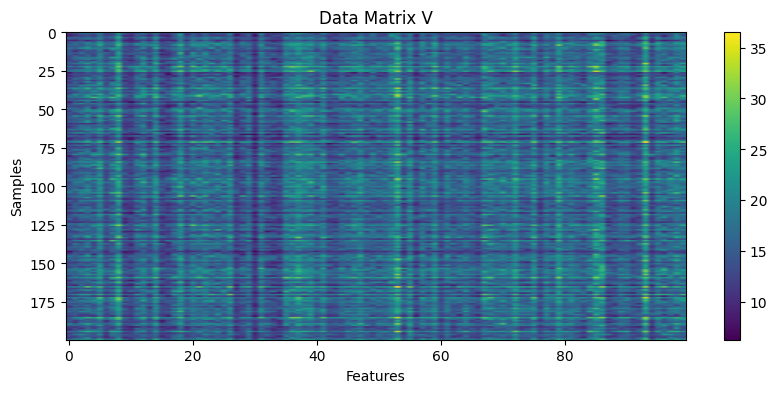

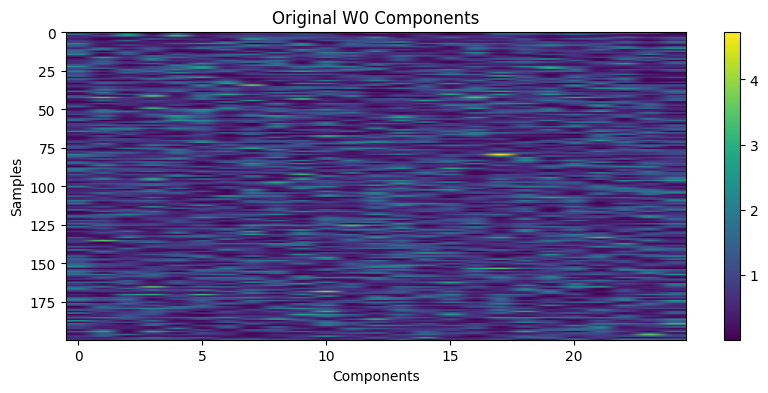

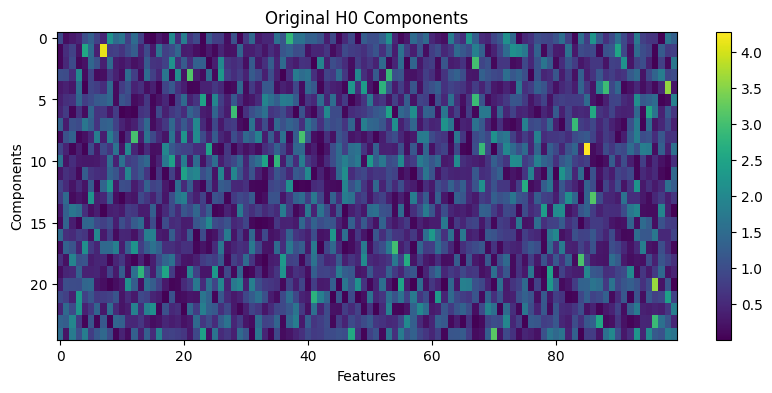

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dataset_NMF(noise_level=0.1):

    # Parameters
    n_samples = 200
    n_features = 100
    n_components = 25
    random_state = 2026

    # Generate random non-negative data matrix V
    np.random.seed(random_state)
    W = np.abs(np.random.randn(n_samples, n_components))
    H = np.abs(np.random.randn(n_components, n_features))
    V = W @ H + noise_level * np.random.randn(n_samples, n_features)
    V = np.clip(V, a_min=0, a_max=None)  # Ensure non-negativity

    return V, W, H

V, W0, H0 = generate_dataset_NMF(noise_level=0)

# display the original components
plt.figure(figsize=(10, 4))
plt.imshow(V, aspect='auto', cmap='viridis')
plt.title('Data Matrix V')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Samples')

# display the original W0 components
plt.figure(figsize=(10, 4))
plt.imshow(W0, aspect='auto', cmap='viridis')
plt.title('Original W0 Components')
plt.colorbar()
plt.xlabel('Components')
plt.ylabel('Samples')

# display the original H0 components

plt.figure(figsize=(10, 4))
plt.imshow(H0, aspect='auto', cmap='viridis')
plt.title('Original H0 Components')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Components')


## Part 2: using NMF on the MNIST dataset

The MNIST dataset is a collection of 70,000 handwritten digit images (0-9), each represented as a 28×28 pixel grayscale image. It is widely used as a benchmark for testing machine learning and image processing algorithms.

**Questions:**
1. Load the MNIST data using the function below. What are the dimensions of the data matrix `V_mnist`? What represents each row of the data matrix? 
2. Plot, for three rows, the corresponding digit image by reshaping the vector as 28x28 array. Compare your observations with the corresponding label, stored in `y_mnist`
3. Apply your best NMF algorithm from Part 1 to the MNIST dataset (`V_mnist`). Choose an appropriate rank $r$. Display the convergence curve of the algorithm. 
4. Visualize the learned basis matrix $W$ as a collection of $r$ images of size 28×28. What patterns do you observe?
5. For a given test image, examine its coefficient vector in $H$. Which components are most active? Can you relate these components to visual features of the digit? Repeat the analysis for randomly selected images. 
7. Investigate the effect of rank $r$ on reconstruction quality and interpretability. What is the trade-off?
8. Compare results obtained by NMF with principal component analysis (PCA). To compute PCA, you can adapt the [scikit-learn example](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to the present situation. 
     - What qualitative differences do you see between PCA and NMF components?  
     - Which representation seems more human-interpretable and why?  
     - Does PCA’s lower reconstruction error necessarily imply better interpretability?




In [34]:
# load MNIST dataset
from sklearn.datasets import fetch_openml
import pandas as pd

def load_mnist_data(truncate=1000):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data / 255.0  # Normalize to [0, 1], contains images as flattened arrays
    y = mnist.target.astype(int) # contains labels as integers
    return X[:truncate], y[:truncate]

V_mnist, y_mnist = load_mnist_data(truncate=1000)

## Part 3: Hierarchical Alternating Least Squares (HALS) (Bonus)

HALS is a powerful and (often) very efficient algorithm for solving NMF. It relies on the column wise update of matrices $W$ and $H$. 
The goal of this section is to implement the HALS algorithm from its description in [N. Gillis paper](https://arxiv.org/pdf/1401.5226); see Section 3.1.5. 

Implement the algorithm and compare its performance on synthetic and MNIST datasets, against projected ALS, BCD and MU algorithms. Comment your results. 